In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv',encoding='latin1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


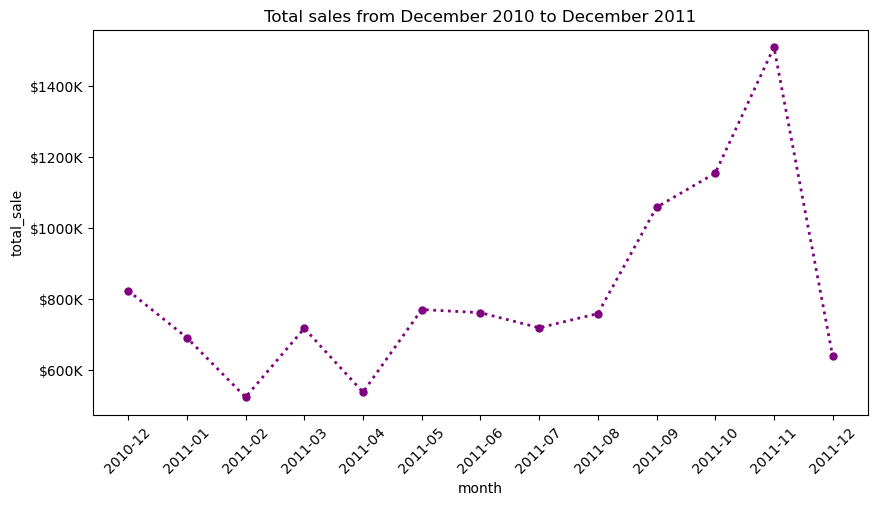

In [33]:
# What are total sales over time?

data['InvoiceDate']= pd.to_datetime(data['InvoiceDate'])

data['month'] = data['InvoiceDate'].dt.strftime('%Y-%m')
data['total_prices'] = data['Quantity'] * data['UnitPrice']
data = data[data['total_prices'] > 0]
total_sale_month = data.groupby('month').agg(total_month_sale = ('total_prices', 'sum'))

plt.figure(figsize= (10,5))
plt.plot(total_sale_month.index,total_sale_month['total_month_sale'],linestyle = ':',linewidth = 2,marker ='o', markersize = 5, color = 'purple')
plt.xticks(rotation = 45)
plt.title('Total sales from December 2010 to December 2011')
plt.xlabel('month')
plt.ylabel('total_sale')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))


Text(0.5, 0, 'Product count')

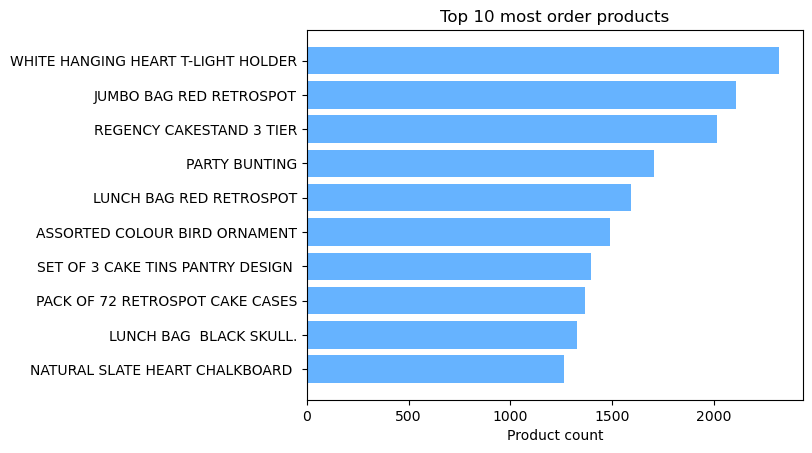

In [34]:
# Which products drive the most revenue?
top_10_products = data['Description'].value_counts().sort_values(ascending= False).head(10)

plt.barh(top_10_products.index,top_10_products.values, color = '#66b3ff')
plt.gca().invert_yaxis()
plt.title('Top 10 most order products')
plt.xlabel('Product count')

Text(0.5, 0, 'Unique customer count')

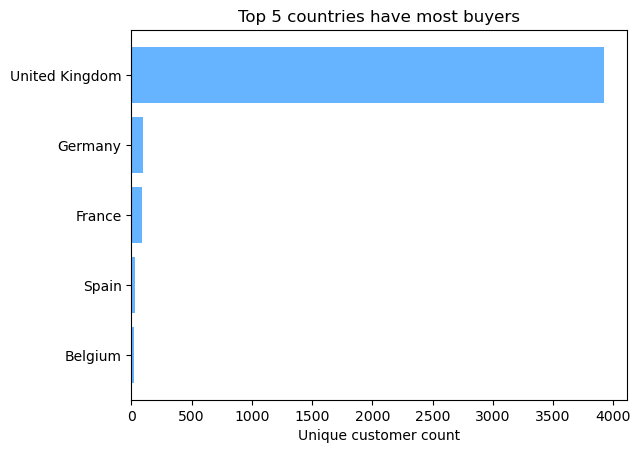

In [35]:
# What countries have the most buyers?

country_buyer = data.groupby('Country').agg(buyer = ('CustomerID','nunique')).sort_values(by= 'buyer',ascending= False).head(5)
plt.barh(country_buyer.index,country_buyer['buyer'], color = '#66b3ff')
plt.gca().invert_yaxis()
plt.title('Top 5 countries have most buyers')
plt.xlabel('Unique customer count')

In [36]:
# How many customers are repeat buyers?

customerid_count = data.groupby('CustomerID').agg(count = ('CustomerID','count')).sort_values(by= 'count',ascending= False)
customerid_count = customerid_count[customerid_count['count'] > 1]
customerid_count

,count
CustomerID,
17841.0,7847
14911.0,5675
14096.0,5111
12748.0,4595
14606.0,2700
...,...
14821.0,2
16716.0,2
12791.0,2


In [37]:
# What is the average order value (AOV)?

Invoice_total_sale = data.groupby('InvoiceNo').agg(total_sale_invoice =('total_prices','sum'))
aov = Invoice_total_sale['total_sale_invoice'].mean()
print(f'average_order_value: ${aov:.2f}')


average_order_value: $534.40


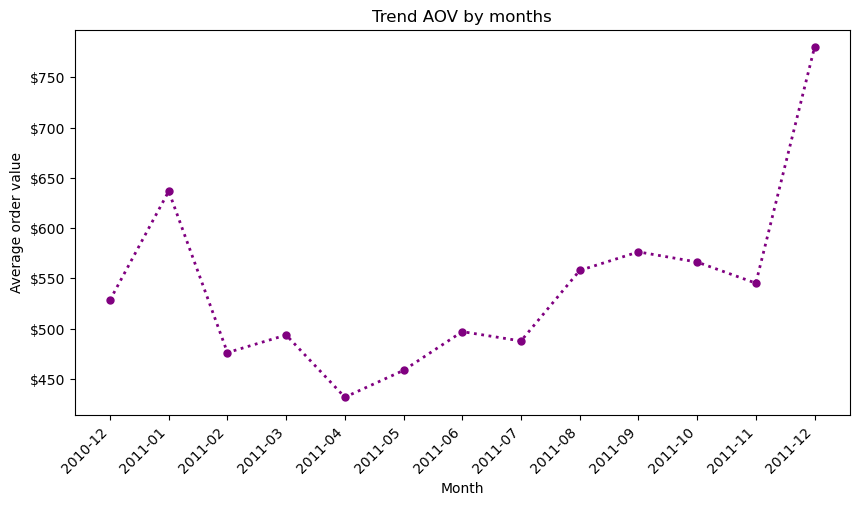

In [38]:
# Analyze AOV throughout monthse
month_order = data.groupby(['month','InvoiceNo']).agg( Total_sale = ('total_prices','sum'))
AOV_month = month_order.groupby('month')['Total_sale'].mean()

plt.figure(figsize=(10,5))
plt.plot(AOV_month.index,AOV_month.values, color = 'purple',linestyle = ':',linewidth = 2,marker ='o', markersize = 5)
plt.xticks(rotation = 45,ha= 'right')
plt.xlabel('Month')
plt.ylabel('Average order value')
plt.title('Trend AOV by months')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y)}'))

/var/folders/hy/zd3zjtb15k9f9916r76r6pj80000gn/T/ipykernel_8704/456720022.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_quatile_range_data['Rolling_mean'] = inner_quatile_range_data['Total_price'].rolling(window=5000).mean()


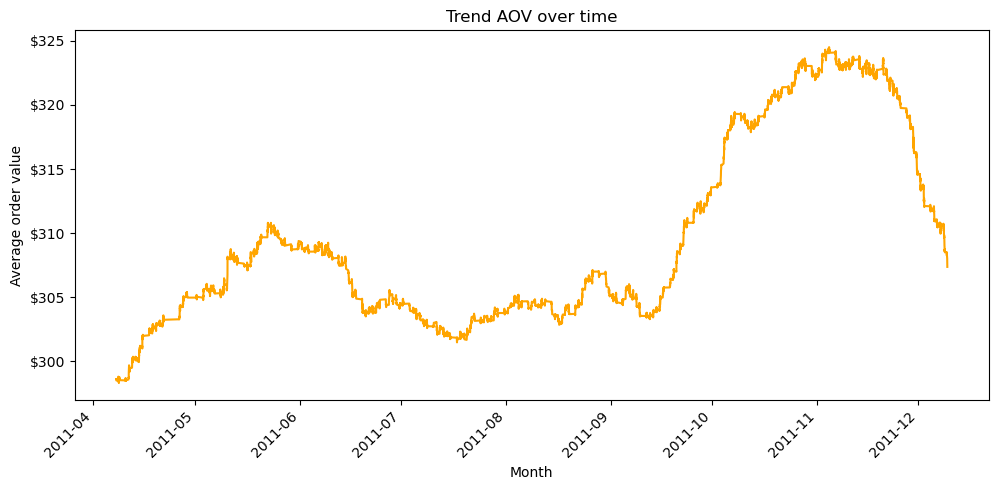

In [39]:
# Analyze AOV overtime

AOV_overtime = data.groupby('InvoiceNo').agg(Total_price = ('total_prices','sum'),
                                             First_date = ('InvoiceDate','min')).sort_values(by = 'First_date')


# Interquatile improve the correctness by removing extreme values

Q1 = AOV_overtime['Total_price'].quantile(0.25)
Q3 = AOV_overtime['Total_price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
inner_quatile_range_data = AOV_overtime[(AOV_overtime['Total_price'] >= lower_bound) & (AOV_overtime['Total_price'] <= upper_bound)]

# Rolling average to understand trend
inner_quatile_range_data['Rolling_mean'] = inner_quatile_range_data['Total_price'].rolling(window=5000).mean()


plt.figure(figsize= (10,5))
plt.plot(inner_quatile_range_data['First_date'],inner_quatile_range_data['Rolling_mean'], color = 'orange')
plt.title('Trend AOV over time')
plt.ylabel('Average order value')
plt.xlabel('Month')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y)}'))

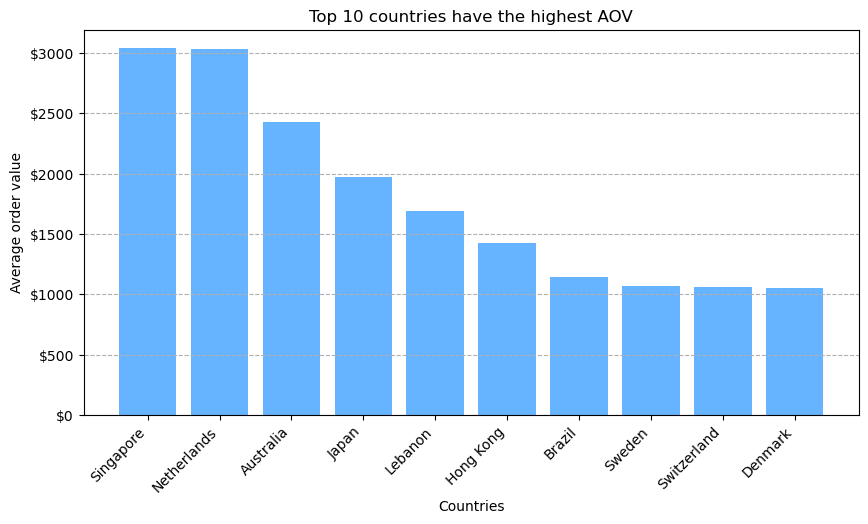

In [40]:
# AOV by country

order_country = data.groupby('InvoiceNo').agg(Country_name = ('Country','first'),Total_sale = ('total_prices','sum'))

AOV_country = order_country.groupby('Country_name')['Total_sale'].mean().sort_values(ascending= False).head(10)

plt.figure(figsize=(10,5))
plt.bar(AOV_country.index,AOV_country.values, color = '#66b3ff')
plt.xticks(rotation = 45, ha = 'right')
plt.title('Top 10 countries have the highest AOV')
plt.ylabel('Average order value')
plt.xlabel('Countries')
plt.grid(axis= 'y',linestyle = '--')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y)}'))

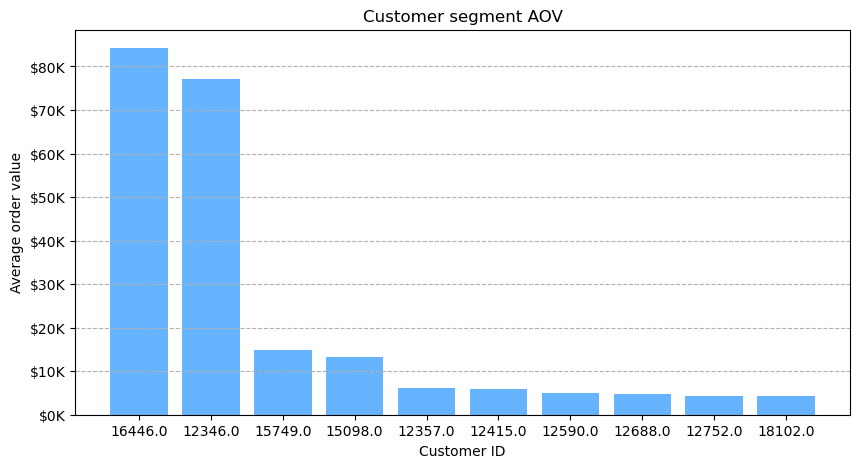

In [41]:
# AOV by Customer Segment

customer_order = data.groupby(['CustomerID','InvoiceNo']).agg(Total_sale = ('total_prices','sum'))
AOV_customer = customer_order.groupby('CustomerID')['Total_sale'].mean().sort_values(ascending= False).head(10)

plt.figure(figsize=(10,5))
plt.bar(AOV_customer.index.astype('str'),AOV_customer.values, color = '#66b3ff')
plt.title('Customer segment AOV')
plt.xlabel('Customer ID')
plt.ylabel('Average order value')
plt.grid(axis= 'y',linestyle = '--')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))

/var/folders/hy/zd3zjtb15k9f9916r76r6pj80000gn/T/ipykernel_8704/2009713842.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_order['short_description'] = return_order['Description'].replace({'SET OF':'','BOX':'','RECIPE':''}, regex = True)
/var/folders/hy/zd3zjtb15k9f9916r76r6pj80000gn/T/ipykernel_8704/2009713842.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_order['product'] = return_order['short_description'].apply(lambda x:" ".join(x.split()[:5]))


Text(0.5, 1.0, 'Percentage of return order')

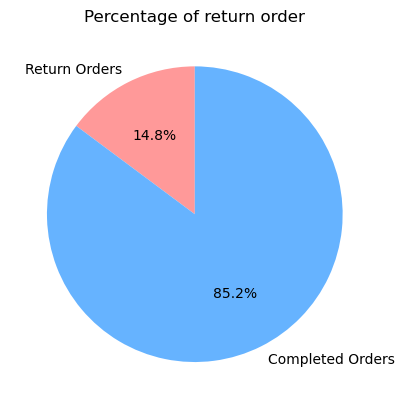

In [42]:
# Analyzing return orders

dt = pd.read_csv('data.csv', encoding = 'latin1')
dt['total_price'] = dt['Quantity'] * dt['UnitPrice']
return_order = dt[dt['InvoiceNo'].astype('str').str.startswith('C')]

return_order['short_description'] = return_order['Description'].replace({'SET OF':'','BOX':'','RECIPE':''}, regex = True)
return_order['product'] = return_order['short_description'].apply(lambda x:" ".join(x.split()[:5]))

unique_return = return_order['InvoiceNo'].nunique()
unique_total = dt['InvoiceNo'].nunique()

unique_return_pct = round(unique_return/unique_total * 100,2)
plt.pie([unique_return,unique_total - unique_return], labels= ['Return Orders','Completed Orders'],startangle=90, autopct= '%1.1f%%',colors=['#ff9999','#66b3ff'])
plt.title('Percentage of return order')


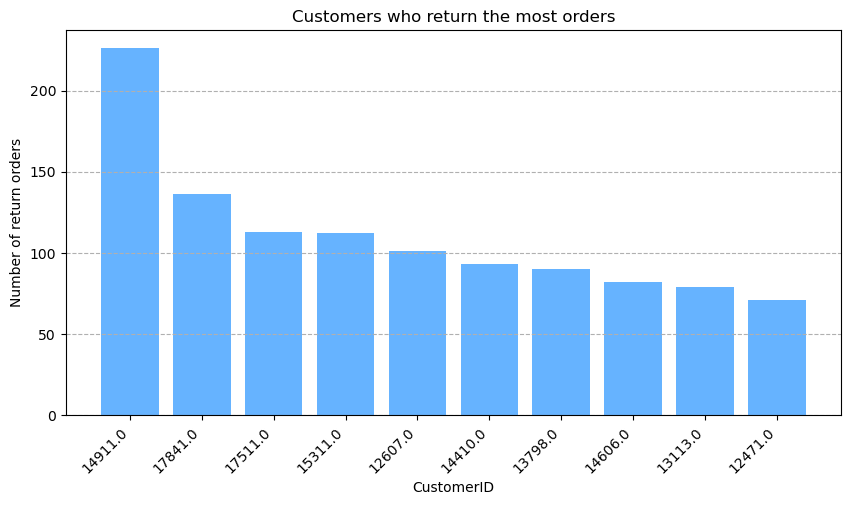

In [43]:
customer_return_Count = return_order['CustomerID'].value_counts().sort_values(ascending= False).head(10)

plt.figure(figsize= (10,5))
plt.bar(customer_return_Count.index.astype('str'),customer_return_Count.values, color = '#66b3ff')
plt.xticks(rotation = 45, ha ='right')
plt.xlabel('CustomerID')
plt.ylabel('Number of return orders')
plt.title('Customers who return the most orders')
plt.grid(axis= 'y',linestyle = '--')

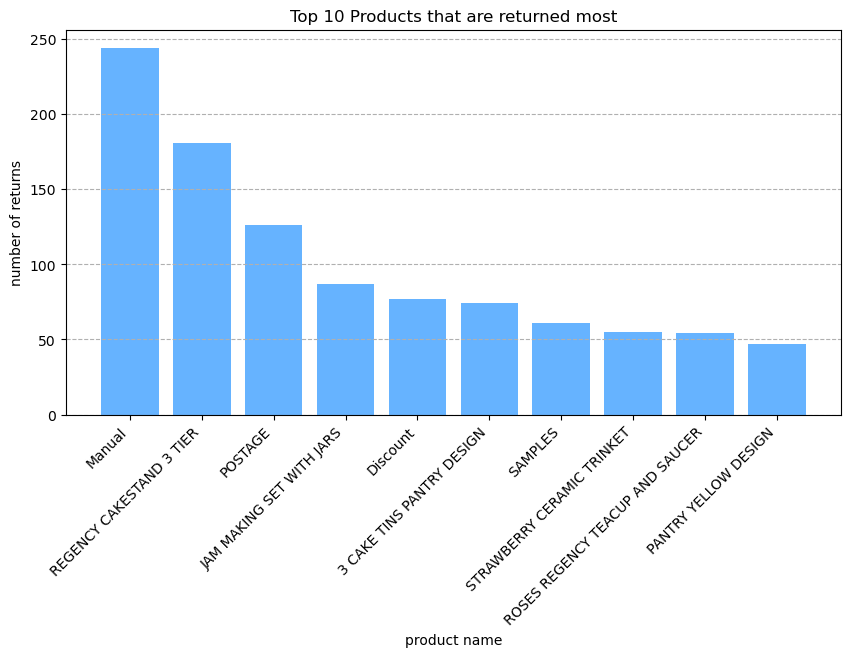

In [44]:

product_return_Count = return_order['product'].value_counts().sort_values(ascending= False).head(10)

plt.figure(figsize= (10,5))
plt.bar(product_return_Count.index.astype('str'),product_return_Count.values, color = '#66b3ff')
plt.xticks(rotation = 45, ha ='right')
plt.title('Top 10 Products that are returned most')
plt.xlabel('product name')
plt.ylabel('number of returns')
plt.grid(axis= 'y',linestyle = '--')

In [45]:
!pip install adjustText

<Figure size 1000x600 with 0 Axes>

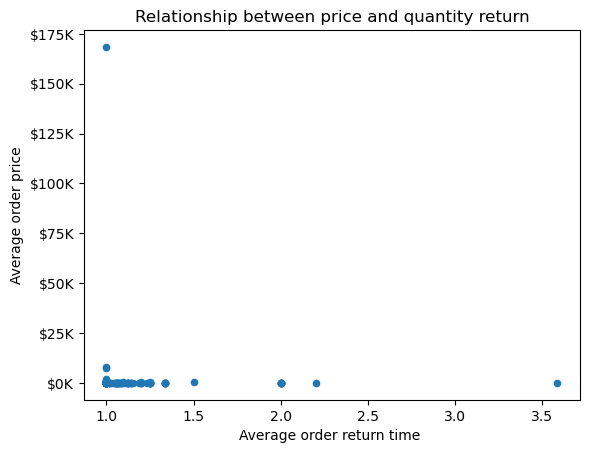

In [46]:
# Relationship between price of product and number of returns

product_price = return_order.groupby(['product','InvoiceNo']).agg(Total_price = ('total_price','sum'),Total_product = ('InvoiceNo','count'))
AOV_product = np.abs(product_price.groupby('product').agg(total_price = ('Total_price','mean'), total_product = ('Total_product','mean')))

plt.figure(figsize=(10, 6))
AOV_product.plot(kind = 'scatter', x ='total_product', y ='total_price' )



plt.title('Relationship between price and quantity return')
plt.ylabel('Average order price')
plt.xlabel('Average order return time ')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))